# Facial Emotion Recogination

## importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [2]:
MIXED_PRECISION = True
XLA_ACCELERATE  = False # Didn't work; Dunno Why!

GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for GPU in GPUS:
            tf.config.experimental.set_memory_growth(GPU, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(GPUS), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
    except RuntimeError as  RE:
        print(RE)

if MIXED_PRECISION:
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')
    
strategy = tf.distribute.get_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}') 
print("Tensorflow version " + tf.__version__)

1 Physical GPUs, 1 Logical GPUs
Mixed precision enabled
REPLICAS: 1
Tensorflow version 2.3.0


In [3]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


### PLot of number of images in training set

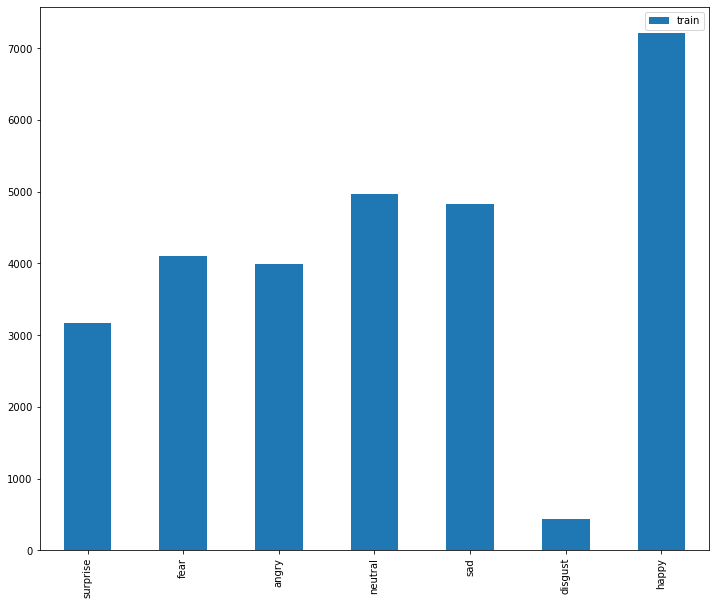

In [4]:

train_count.transpose().plot(kind='bar', figsize=(12,10))

### PLot of number of images in test set

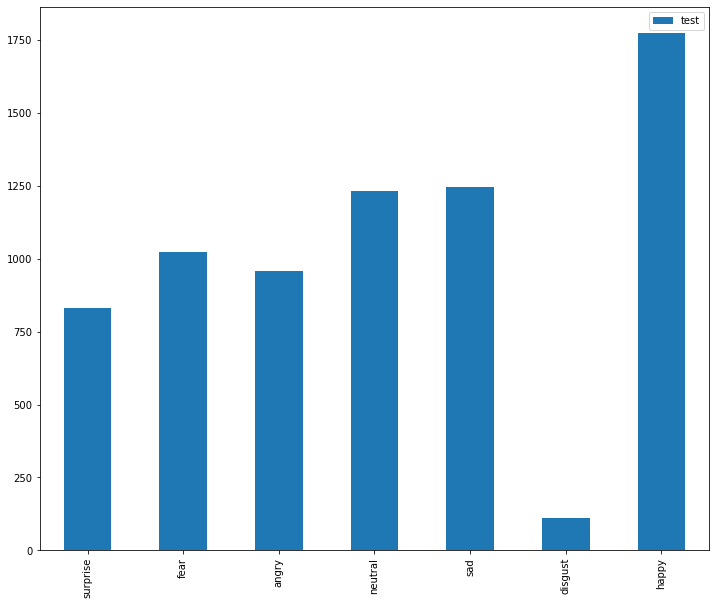

In [5]:
test_count.transpose().plot(kind='bar',figsize=(12, 10))

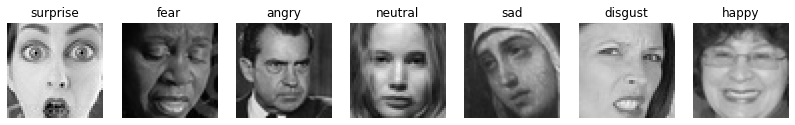

In [6]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [7]:
image_size= 48
batch_size= 64
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(image_size, image_size),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(image_size, image_size),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Defining Model

In [9]:
def model_1(input_size, classes=7):
     
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [10]:
def model_2(input_size, classes=7):
    model= tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #Faltten the model
    model.add(Flatten())
    
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(classes, activation='softmax'))
    opt = Adam(lr=0.0005 , decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary
    return model
    

In [11]:
model_1 = model_1((row,col,1), classes)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

In [12]:
model_2 = model_2((row,col,1), classes)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 128)      

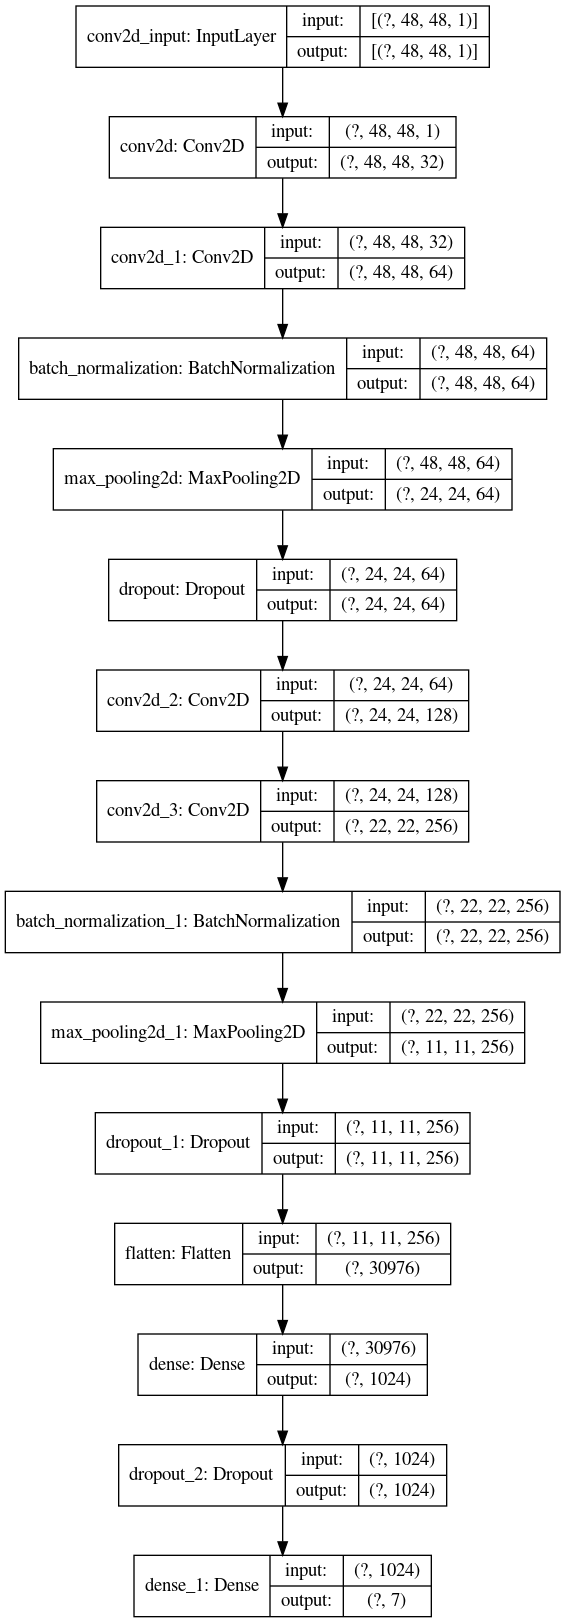

In [13]:
plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

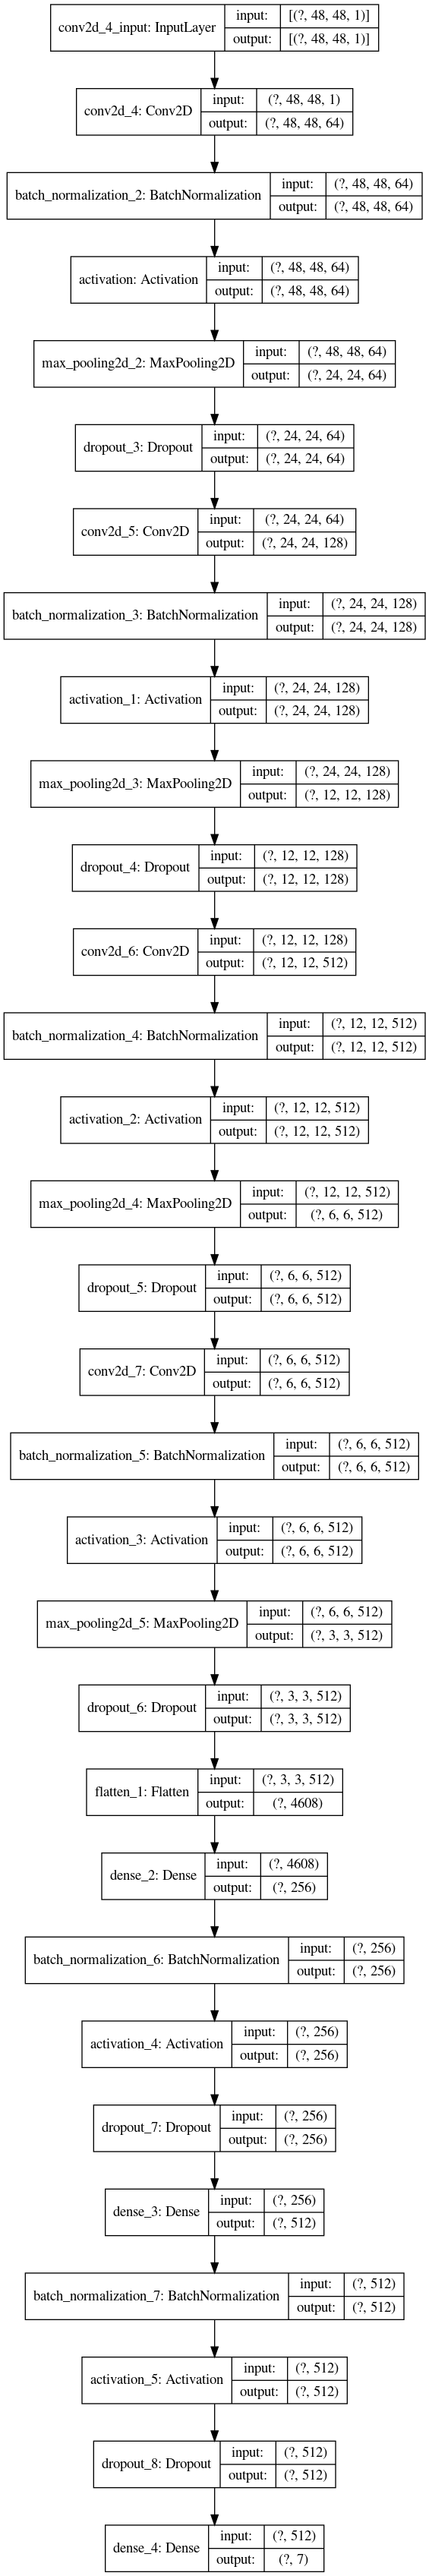

In [14]:
plot_model(model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True)

### Callbacks Function

In [15]:
chk_path = 'model_1.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

## Training Model

In [16]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = model_1.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.3056 - accuracy: 0.2755
Epoch 00001: val_loss improved from inf to 5.67188, saving model to model_1.h5
448/448 [==============================] - 176s 392ms/step - loss: 4.3056 - accuracy: 0.2755 - val_loss: 5.6719 - val_accuracy: 0.3262
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.5311 - accuracy: 0.3321
Epoch 00002: val_loss improved from 5.67188 to 3.15045, saving model to model_1.h5
448/448 [==============================] - 38s 84ms/step - loss: 3.5311 - accuracy: 0.3321 - val_loss: 3.1505 - val_accuracy: 0.3954
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 3.0334 - accuracy: 0.3637
Epoch 00003: val_loss improved from 3.15045 to 2.70868, saving model to model_1.h5
448/448 [==============================] - 37s 83ms/step - loss: 3.0334 - accuracy: 0.3637 - val_loss: 2.7087 - val_accuracy: 0.4181
Epoch 4/60
448/448 [==============================] - ETA: 0s - lo

Epoch 28/60
448/448 [==============================] - ETA: 0s - loss: 0.9112 - accuracy: 0.6968
Epoch 00028: val_loss did not improve from 1.08591
448/448 [==============================] - 37s 83ms/step - loss: 0.9112 - accuracy: 0.6968 - val_loss: 1.0883 - val_accuracy: 0.6396
Epoch 29/60
448/448 [==============================] - ETA: 0s - loss: 0.8864 - accuracy: 0.7055
Epoch 00029: val_loss did not improve from 1.08591
448/448 [==============================] - 38s 84ms/step - loss: 0.8864 - accuracy: 0.7055 - val_loss: 1.1024 - val_accuracy: 0.6371
Epoch 30/60
448/448 [==============================] - ETA: 0s - loss: 0.8725 - accuracy: 0.7104
Epoch 00030: val_loss did not improve from 1.08591

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
448/448 [==============================] - 38s 85ms/step - loss: 0.8725 - accuracy: 0.7104 - val_loss: 1.1283 - val_accuracy: 0.6345
Epoch 31/60
448/448 [==============================] - ETA: 0s - loss: 0.80

Epoch 56/60
448/448 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.7810
Epoch 00056: val_loss did not improve from 1.08028
448/448 [==============================] - 36s 79ms/step - loss: 0.6828 - accuracy: 0.7810 - val_loss: 1.0933 - val_accuracy: 0.6557
Epoch 57/60
448/448 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.7815
Epoch 00057: val_loss did not improve from 1.08028
448/448 [==============================] - 36s 80ms/step - loss: 0.6848 - accuracy: 0.7815 - val_loss: 1.0947 - val_accuracy: 0.6557
Epoch 58/60
448/448 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.7811
Epoch 00058: val_loss did not improve from 1.08028
448/448 [==============================] - 36s 79ms/step - loss: 0.6840 - accuracy: 0.7811 - val_loss: 1.0942 - val_accuracy: 0.6557
Epoch 59/60
448/448 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.7820
Epoch 00059: val_loss did not improve from 1.08028
448/448 [

# Check Model_2

In [17]:
chk_path_2 = 'model_2.h5'
log_dir_2 = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint_2 = ModelCheckpoint(filepath=chk_path_2,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop_2 = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir_2, histogram_freq=1)
csv_logger_2 = CSVLogger('training.log')

callback_2 = [checkpoint_2, reduce_lr_2, csv_logger_2]

In [ ]:


model_2_hist = model_2.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callback_2,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 1.8799 - accuracy: 0.2643
Epoch 00001: val_loss improved from inf to 1.80043, saving model to model_2.h5
448/448 [==============================] - 37s 82ms/step - loss: 1.8799 - accuracy: 0.2643 - val_loss: 1.8004 - val_accuracy: 0.2979
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 1.6441 - accuracy: 0.3605
Epoch 00002: val_loss improved from 1.80043 to 1.61715, saving model to model_2.h5
448/448 [==============================] - 37s 82ms/step - loss: 1.6441 - accuracy: 0.3605 - val_loss: 1.6172 - val_accuracy: 0.3803
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 1.4828 - accuracy: 0.4279
Epoch 00003: val_loss improved from 1.61715 to 1.45532, saving model to model_2.h5
448/448 [==============================] - 37s 84ms/step - loss: 1.4828 - accuracy: 0.4279 - val_loss: 1.4553 - val_accuracy: 0.4413
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss

## Loss and Accuracy plot

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(model_2_hist.history['accuracy'])
plt.plot(model_2_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(model_2_hist.history['loss'])
plt.plot(model_2_hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Model 2 shows best result , so we will approach that.**

### Model evaluation

In [ ]:
def model_data(model):
    train_loss, train_accu = model.evaluate(training_set)
    test_loss, test_accu = model.evaluate(test_set)
    return print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
model_data(model_1)

In [ ]:
model_data(model_2)

In [ ]:
model_1.save_weights('model_1_bestweight.h5')

In [ ]:
model_2.save_weights('model_2_bestweight.h5')

### Confusion Matrix and Classification on training set

In [ ]:
y_pred = model_2.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion Matrix and Classification on test set

In [ ]:
y_pred = model_1.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)